#Library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AdamW, get_linear_schedule_with_warmup
from torchvision.models import resnet152, ResNet50_Weights
from PIL import Image
import seaborn as sns
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import albumentations as A
import cv2
import warnings
warnings.filterwarnings('ignore')


sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_r=pd.read_csv('/content/drive/MyDrive/data/train_r.csv')
train_p=pd.read_csv('/content/drive/MyDrive/data/train_p.csv')

valid_r=pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')
valid_p=pd.read_csv('/content/drive/MyDrive/data/valid_p.csv')

test_r=pd.read_csv('/content/drive/MyDrive/data/test_r.csv')
test_p=pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

In [5]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

#Config

In [6]:
#device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#batch size
batch_size = 16

# params
epoch = 20
patience = 2
factor = 0.3
# loss function
loss_fn = nn.CrossEntropyLoss().to(device)

res_lr = 0.001
transformers = transforms=A.Compose(
            [A.Resize(255, 255, always_apply=True),
             A.Normalize(max_pixel_value=255.0, always_apply=True)])

n_train_p=len(train_p)
n_valid_p=len(valid_p)
n_train_r=len(train_r)
n_valid_r=len(valid_r)

train_img_p = '/content/drive/MyDrive/data/train_P_image/'
test_img_p = '/content/drive/MyDrive/data/test_P_image/'

train_img_r = '/content/drive/MyDrive/data/train_R_image/'
test_img_r = '/content/drive/MyDrive/data/test_R_image/'


# Model

In [7]:
class AudioCNNDataset(Dataset):
    def __init__(self, img_names, img_dir, target, transforms):
      super(AudioCNNDataset, self).__init__()
      self.img_names = img_names+'.jpg'
      self.img_dir = img_dir
      self.target = target
      self.transforms = transforms

    def __getitem__(self, index):
      item = {}
      image = cv2.imread(f"{self.img_dir}{self.img_names[index]}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = self.transforms(image=image)['image']
      item['target'] = self.target[index]
      item['image'] = torch.tensor(image).permute(2, 0, 1).float()

      return item


    def __len__(self):
      return len(self.img_names)


def create_audio_loader(df, img_dir, shuffle=True):
  ds = AudioCNNDataset(target=df['index'].values,
                       img_names= df['file_name'].values,
                       img_dir=img_dir,
                       transforms=transforms)

  return DataLoader(ds,
                    batch_size=batch_size
                    ,shuffle=shuffle)

In [8]:
class Resnet152(nn.Module):

  def __init__(self, n_classes):
    super(Resnet152, self).__init__()
    self.premodel = resnet152(weights="IMAGENET1K_V2")
    modules=list(self.premodel.children())[:-1]
    self.model=nn.Sequential(*modules)
    self.fc=nn.Linear(2048, n_classes)

  def forward(self, image):
    out = self.model(image)
    output=out.flatten(1)
    logits=self.fc(output)
    probas = F.softmax(logits, dim=1)

    return logits, probas

In [ ]:
def train_epoch(model, train_dataloader, optimizer,n_train):
    model = model.train() # puts the model in training mode
    correct=0
    running_loss = 0.0
    process_bar = tqdm(train_dataloader)
    for batch in process_bar:
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)
      optimizer.zero_grad() # clear the gradients in model parameters
      logits, probas = model(audio) # put data into model to predict
      loss = loss_fn(logits, targets) # calculate loss between prediction and true labels
      loss.backward() # back propagation: pass the loss
      optimizer.step()  # iterate over all parameters in the model with requires_grad=True and update their weights.
      # compute training statistics
      _, predicted = torch.max(logits, 1)
      correct += (predicted == targets).sum().item()
      running_loss += loss.item() # sum total loss in current epoch for print later
      process_bar.set_postfix(train_loss=loss.item())

    avg_loss = running_loss / n_train
    avg_acc = correct / n_train

    return avg_acc,avg_loss

def eval_model(model, val_dataloader, n_valid):
    model=model.eval() # puts the model in validation mode
    correct=0
    running_loss = 0.0
    process_bar = tqdm(val_dataloader)
    for batch in process_bar:
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)
      logits, probas = model(audio) # put data into model to predict
      loss = loss_fn(logits, targets) # calculate loss between prediction and true labels
      _, predicted = torch.max(logits, 1)
      correct += (predicted == targets).sum().item()
      running_loss += loss.item() # sum total loss in current epoch for print later
      process_bar.set_postfix(val_loss=loss.item())

    avg_loss = running_loss / n_valid
    avg_acc = correct / n_valid
    return avg_acc,avg_loss
def get_predictions(model, test_dataloader):
  model=model.eval()
  predictions=[]
  real_values=[]
  for batch in tqdm(test_dataloader):
      targets = batch["target"].to(device)
      audio=batch['image'].to(device)

      logits, probas = model(audio)
      _, predicted_labels = torch.max(probas, 1)

      predictions.extend(predicted_labels)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  real_values = torch.stack(real_values).cpu()

  return predictions, real_values

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Researcher

In [ ]:
train_dataloader = create_audio_loader(train_r, train_img_r, shuffle=True)
val_dataloader = create_audio_loader(valid_r, test_img_r ,shuffle=False)
test_dataloader = create_audio_loader(test_r, test_img_r ,shuffle=False)

In [ ]:
model=Resnet152(5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=res_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=factor)

for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader,
                                       optimizer,
                                       n_train_r)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader, n_valid_r)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_res152.pt')

Epoch 1/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.80it/s, train_loss=1.6]


Train loss 0.08200845105944425 accuracy 0.5297029702970297


100%|██████████| 15/15 [00:01<00:00, 13.94it/s, val_loss=1.08]


Val loss 0.0885501718311979 accuracy 0.5087719298245614

Epoch 2/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.82it/s, train_loss=1.48]


Train loss 0.07628466315133081 accuracy 0.5665566556655666


100%|██████████| 15/15 [00:01<00:00, 14.09it/s, val_loss=3.2]


Val loss 0.11801198961441978 accuracy 0.45614035087719296

Epoch 3/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.68it/s, train_loss=1.59]


Train loss 0.07470084872707414 accuracy 0.5720572057205721


100%|██████████| 15/15 [00:01<00:00, 14.20it/s, val_loss=2.15]


Val loss 0.08575140959338139 accuracy 0.5

Epoch 4/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.81it/s, train_loss=1.42]


Train loss 0.07302376050891393 accuracy 0.5869086908690869


100%|██████████| 15/15 [00:01<00:00, 14.23it/s, val_loss=0.958]


Val loss 0.08345413574001245 accuracy 0.5131578947368421

Epoch 5/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.79it/s, train_loss=1.43]


Train loss 0.07036355724691426 accuracy 0.5918591859185919


100%|██████████| 15/15 [00:01<00:00, 13.56it/s, val_loss=1.32]


Val loss 0.07836722726361793 accuracy 0.5614035087719298

Epoch 6/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.82it/s, train_loss=0.846]


Train loss 0.0693077194874305 accuracy 0.605060506050605


100%|██████████| 15/15 [00:01<00:00, 13.54it/s, val_loss=1.15]


Val loss 0.08551940792485287 accuracy 0.5307017543859649

Epoch 7/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.82it/s, train_loss=1.15]


Train loss 0.06529196473893815 accuracy 0.6226622662266227


100%|██████████| 15/15 [00:01<00:00, 14.06it/s, val_loss=1.1]


Val loss 0.08241687610484007 accuracy 0.5614035087719298

Epoch 8/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.84it/s, train_loss=0.982]


Train loss 0.06104496849252052 accuracy 0.6523652365236524


100%|██████████| 15/15 [00:01<00:00, 14.33it/s, val_loss=1.17]


Val loss 0.08461590947812064 accuracy 0.5570175438596491

Epoch 9/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.69it/s, train_loss=0.51]


Train loss 0.04768347643455132 accuracy 0.7090209020902091


100%|██████████| 15/15 [00:01<00:00, 14.62it/s, val_loss=0.931]


Val loss 0.08415014492838006 accuracy 0.5350877192982456

Epoch 10/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.82it/s, train_loss=0.386]


Train loss 0.031405079523787904 accuracy 0.8195819581958196


100%|██████████| 15/15 [00:01<00:00, 14.09it/s, val_loss=1.11]


Val loss 0.10710338594620689 accuracy 0.5833333333333334

Epoch 11/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.74it/s, train_loss=0.552]


Train loss 0.01886666609984551 accuracy 0.8927392739273927


100%|██████████| 15/15 [00:01<00:00, 13.61it/s, val_loss=2.32]


Val loss 0.12964344442936412 accuracy 0.5219298245614035

Epoch 12/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.71it/s, train_loss=0.0412]


Train loss 0.010349057383253367 accuracy 0.9521452145214522


100%|██████████| 15/15 [00:01<00:00, 13.60it/s, val_loss=0.819]


Val loss 0.11730576215083138 accuracy 0.5482456140350878

Epoch 13/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.77it/s, train_loss=0.115]


Train loss 0.005199996780141024 accuracy 0.9818481848184818


100%|██████████| 15/15 [00:01<00:00, 14.09it/s, val_loss=1.17]


Val loss 0.1260098616282145 accuracy 0.5394736842105263

Epoch 14/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.80it/s, train_loss=0.16]


Train loss 0.0029133256297861816 accuracy 0.9922992299229924


100%|██████████| 15/15 [00:01<00:00, 14.44it/s, val_loss=0.88]


Val loss 0.13286516933064713 accuracy 0.5526315789473685

Epoch 15/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.80it/s, train_loss=0.00612]


Train loss 0.0019322351612866835 accuracy 0.9961496149614961


100%|██████████| 15/15 [00:01<00:00, 14.39it/s, val_loss=1.2]


Val loss 0.14119689454112136 accuracy 0.5482456140350878

Epoch 16/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.82it/s, train_loss=0.00562]


Train loss 0.0015860734260523214 accuracy 0.9966996699669967


100%|██████████| 15/15 [00:01<00:00, 14.14it/s, val_loss=1.41]


Val loss 0.14864955554928697 accuracy 0.543859649122807

Epoch 17/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.63it/s, train_loss=0.0169]


Train loss 0.00131489728268531 accuracy 0.9972497249724972


100%|██████████| 15/15 [00:01<00:00, 13.47it/s, val_loss=1.11]


Val loss 0.14698907471539682 accuracy 0.5482456140350878

Epoch 18/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.68it/s, train_loss=0.139]


Train loss 0.001258610370269248 accuracy 0.9977997799779978


100%|██████████| 15/15 [00:01<00:00, 13.74it/s, val_loss=1.19]


Val loss 0.1514867199094672 accuracy 0.5394736842105263

Epoch 19/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.79it/s, train_loss=0.09]


Train loss 0.0013424873087458861 accuracy 0.9955995599559956


100%|██████████| 15/15 [00:01<00:00, 14.44it/s, val_loss=1.22]


Val loss 0.1487525340757872 accuracy 0.5482456140350878

Epoch 20/20
----------


100%|██████████| 114/114 [00:14<00:00,  7.76it/s, train_loss=0.0088]


Train loss 0.0010779389853313118 accuracy 0.9961496149614961


100%|██████████| 15/15 [00:01<00:00, 14.26it/s, val_loss=1.09]


Val loss 0.1499737166521842 accuracy 0.5394736842105263



In [ ]:
with torch.no_grad():
    y_pred, y_test=get_predictions(model, test_dataloader)

100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


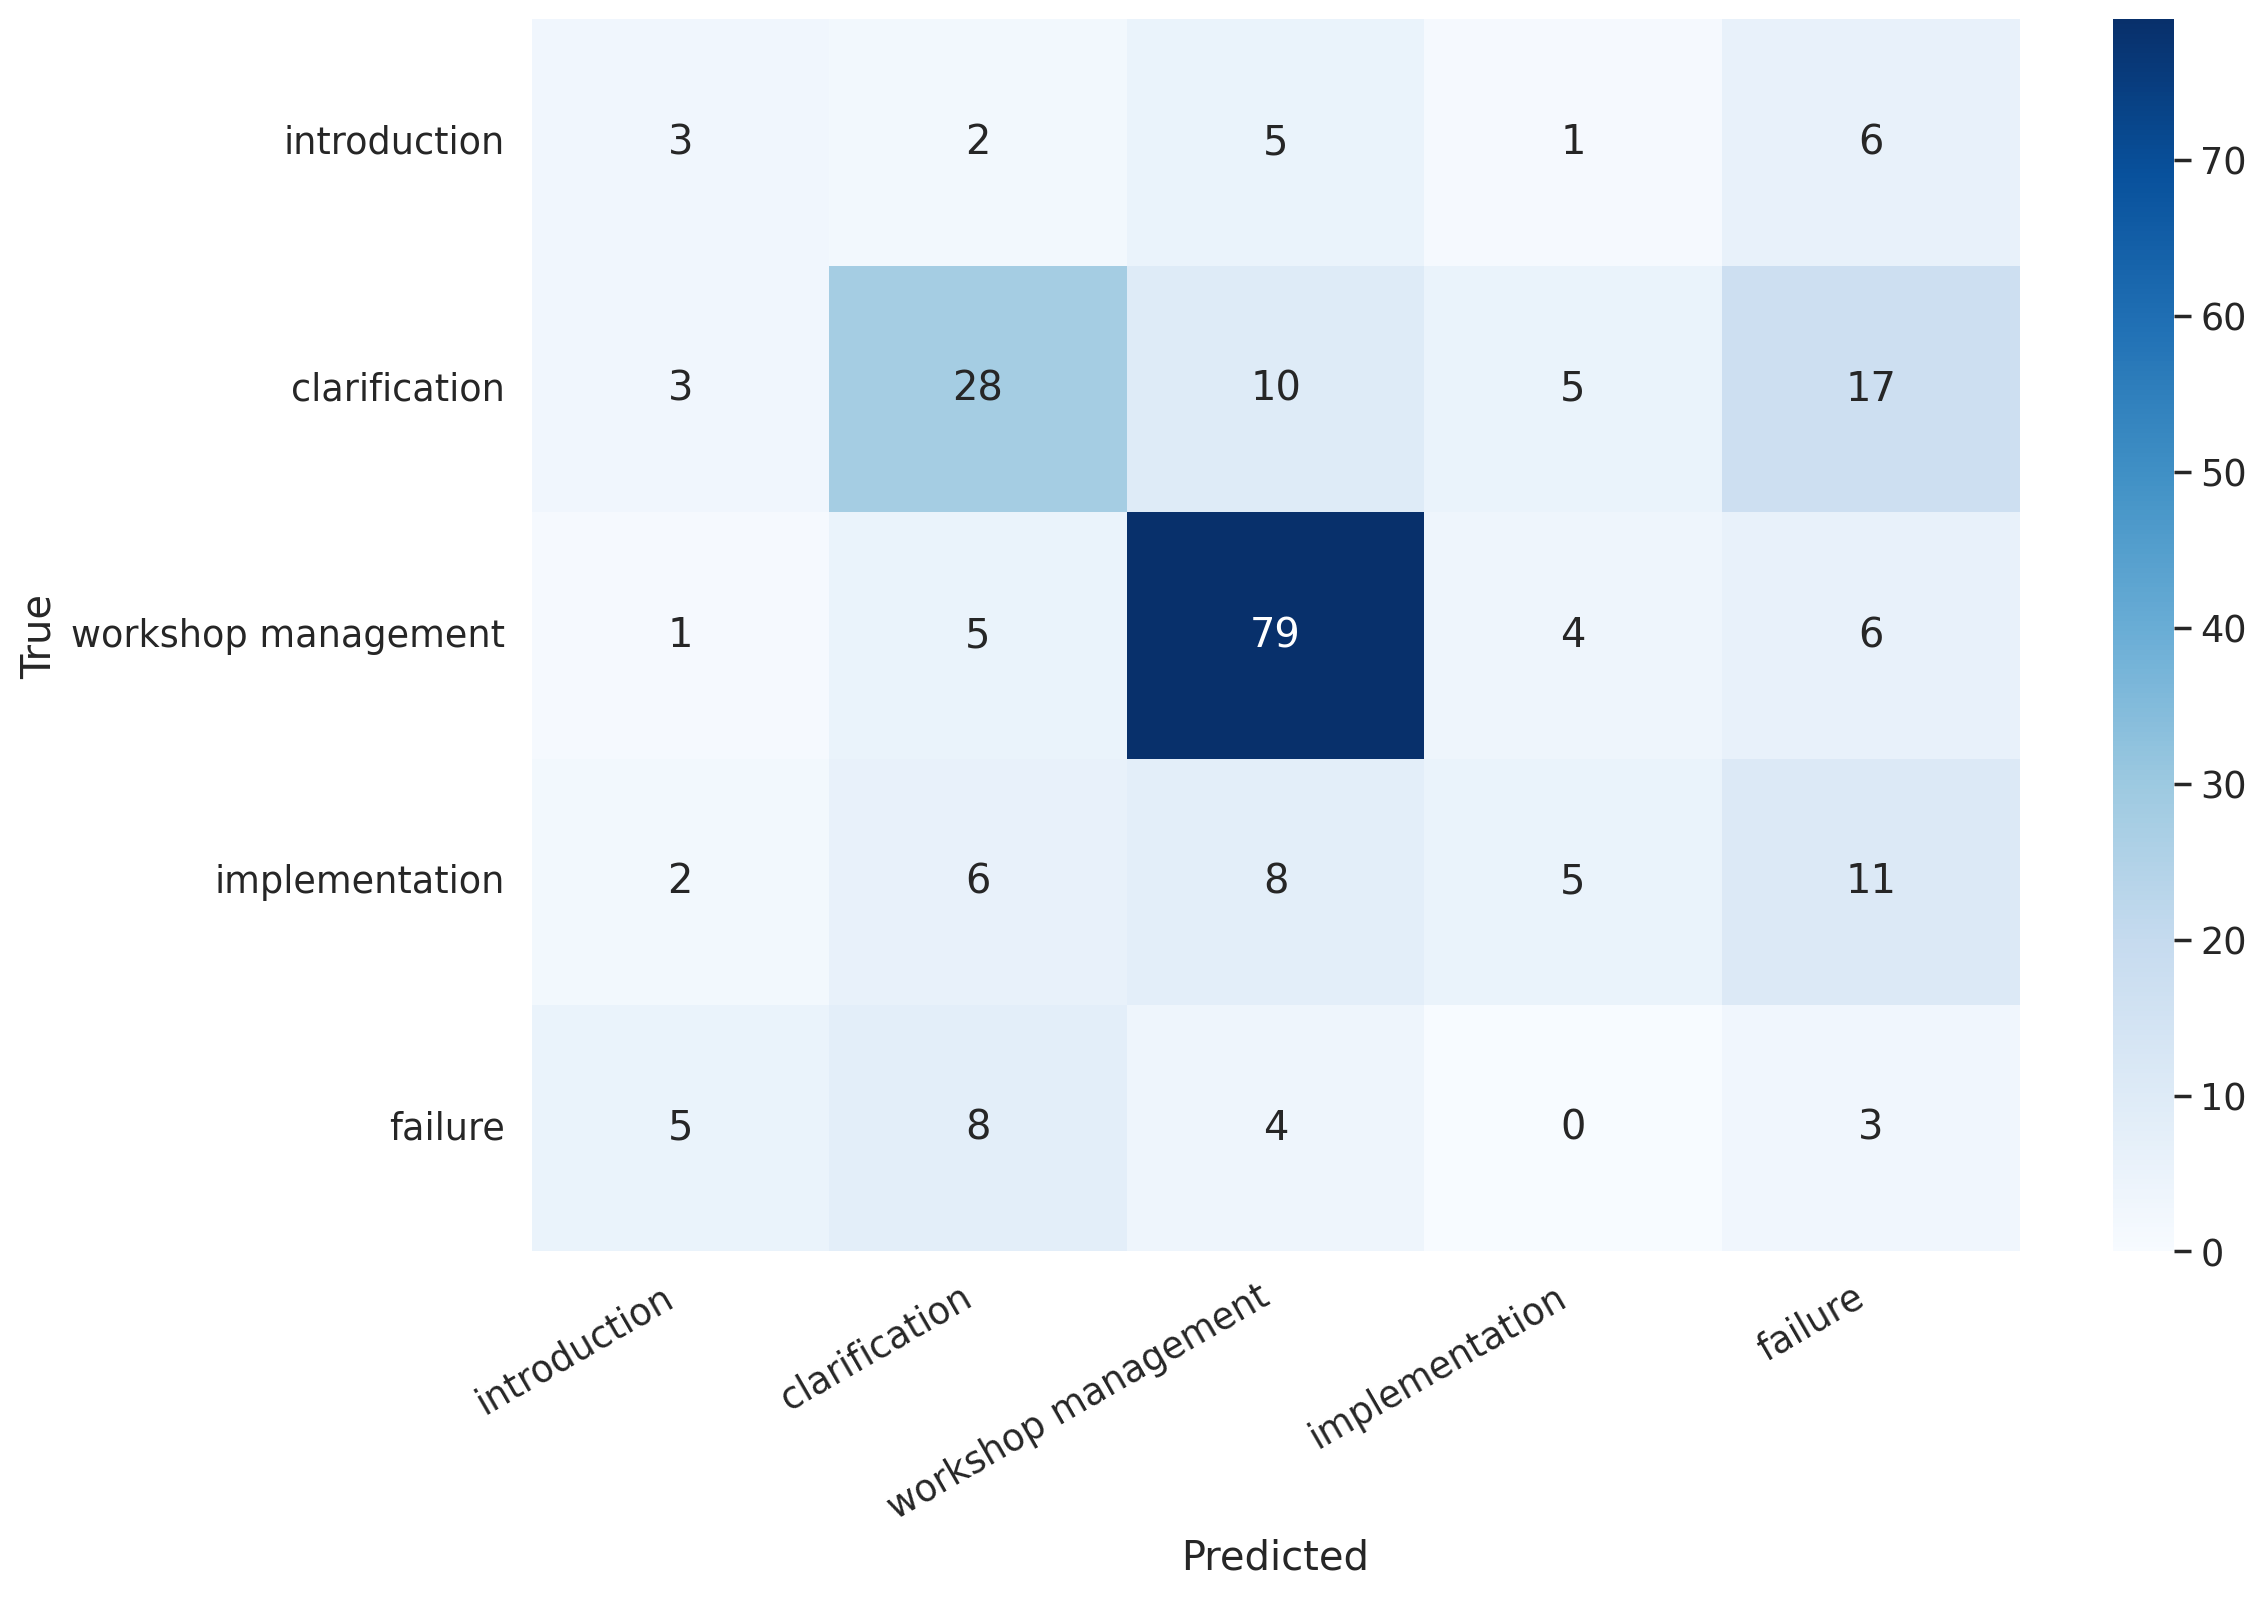

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.21      0.18      0.19        17
      clarification       0.57      0.44      0.50        63
workshop management       0.75      0.83      0.79        95
     implementation       0.33      0.16      0.21        32
            failure       0.07      0.15      0.10        20

           accuracy                           0.52       227
          macro avg       0.39      0.35      0.36       227
       weighted avg       0.54      0.52      0.52       227



# Participant


In [ ]:
train_dataloader_p = create_audio_loader(train_p, train_img_p, shuffle=True)
val_dataloader_p = create_audio_loader(valid_p, test_img_p ,shuffle=False)
test_dataloader_p = create_audio_loader(test_p, test_img_p ,shuffle=False)

In [ ]:
model=Resnet152(5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=res_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
optimizer, mode="min", patience=patience, factor=factor)

for e in range(epoch):

    print(f'Epoch {e + 1}/{epoch}')
    print('-' * 10)
    train_acc, train_loss= train_epoch(model,
                                       train_dataloader_p,
                                       optimizer,
                                       n_train_p)

    print(f'Train loss {train_loss} accuracy {train_acc}')
    with torch.no_grad():
        val_acc ,val_loss= eval_model(model,val_dataloader_p, n_valid_p)


    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()
    scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_res152.pt')


Epoch 1/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.65it/s, train_loss=1.46]


Train loss 0.09563372043019908 accuracy 0.31538992408557626


100%|██████████| 12/12 [00:00<00:00, 13.90it/s, val_loss=1.49]


Val loss 0.10016412394387382 accuracy 0.2857142857142857

Epoch 2/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.77it/s, train_loss=1.43]


Train loss 0.09399018335375316 accuracy 0.2836438923395445


100%|██████████| 12/12 [00:00<00:00, 14.01it/s, val_loss=2.72]


Val loss 0.12297041927065168 accuracy 0.3131868131868132

Epoch 3/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.70it/s, train_loss=1.72]


Train loss 0.09394667031766629 accuracy 0.29675638371290547


100%|██████████| 12/12 [00:00<00:00, 13.99it/s, val_loss=1.56]


Val loss 0.1003458375459189 accuracy 0.3241758241758242

Epoch 4/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.86it/s, train_loss=1.54]


Train loss 0.09308789778446806 accuracy 0.30158730158730157


100%|██████████| 12/12 [00:00<00:00, 14.21it/s, val_loss=1.63]


Val loss 0.09862778671495206 accuracy 0.32967032967032966

Epoch 5/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.65it/s, train_loss=1.59]


Train loss 0.09223106723558994 accuracy 0.2836438923395445


100%|██████████| 12/12 [00:00<00:00, 13.93it/s, val_loss=1.61]


Val loss 0.1008263669171176 accuracy 0.34065934065934067

Epoch 6/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.82it/s, train_loss=1.36]


Train loss 0.09220631983133741 accuracy 0.3112491373360939


100%|██████████| 12/12 [00:00<00:00, 14.24it/s, val_loss=1.64]


Val loss 0.11068675675234951 accuracy 0.2802197802197802

Epoch 7/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.77it/s, train_loss=1.53]


Train loss 0.09138214489441233 accuracy 0.3140096618357488


100%|██████████| 12/12 [00:00<00:00, 13.95it/s, val_loss=1.59]


Val loss 0.10031027191287868 accuracy 0.32967032967032966

Epoch 8/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.80it/s, train_loss=1.21]


Train loss 0.08887104250958576 accuracy 0.3416149068322981


100%|██████████| 12/12 [00:00<00:00, 13.95it/s, val_loss=1.54]


Val loss 0.10301132713045393 accuracy 0.32967032967032966

Epoch 9/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.81it/s, train_loss=1.49]


Train loss 0.08716802748422774 accuracy 0.36783988957902003


100%|██████████| 12/12 [00:00<00:00, 14.34it/s, val_loss=1.51]


Val loss 0.10262172955733079 accuracy 0.3076923076923077

Epoch 10/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.79it/s, train_loss=1.23]


Train loss 0.08541210352592916 accuracy 0.3961352657004831


100%|██████████| 12/12 [00:00<00:00, 13.19it/s, val_loss=1.58]


Val loss 0.11351233786279029 accuracy 0.29120879120879123

Epoch 11/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.77it/s, train_loss=1.1]


Train loss 0.08146069418404989 accuracy 0.42857142857142855


100%|██████████| 12/12 [00:00<00:00, 13.80it/s, val_loss=1.45]


Val loss 0.10480437632445451 accuracy 0.34615384615384615

Epoch 12/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.83it/s, train_loss=1.37]


Train loss 0.0759051483692672 accuracy 0.4803312629399586


100%|██████████| 12/12 [00:00<00:00, 13.53it/s, val_loss=1.45]


Val loss 0.10698378413588136 accuracy 0.31868131868131866

Epoch 13/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.85it/s, train_loss=1.23]


Train loss 0.07063413744058339 accuracy 0.52864044168392


100%|██████████| 12/12 [00:00<00:00, 13.90it/s, val_loss=1.7]


Val loss 0.11779512284876226 accuracy 0.2967032967032967

Epoch 14/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.66it/s, train_loss=1.38]


Train loss 0.06115672677200033 accuracy 0.6162870945479642


100%|██████████| 12/12 [00:00<00:00, 13.99it/s, val_loss=1.28]


Val loss 0.11630586149928333 accuracy 0.31868131868131866

Epoch 15/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.80it/s, train_loss=0.752]


Train loss 0.05371883233881885 accuracy 0.6783988957902002


100%|██████████| 12/12 [00:00<00:00, 14.03it/s, val_loss=1.25]


Val loss 0.1266056076510922 accuracy 0.2857142857142857

Epoch 16/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.80it/s, train_loss=0.627]


Train loss 0.04704415057756886 accuracy 0.7101449275362319


100%|██████████| 12/12 [00:00<00:00, 14.55it/s, val_loss=1.31]


Val loss 0.13215669891336462 accuracy 0.2967032967032967

Epoch 17/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.75it/s, train_loss=0.509]


Train loss 0.04174600205312851 accuracy 0.7536231884057971


100%|██████████| 12/12 [00:00<00:00, 14.17it/s, val_loss=1.42]


Val loss 0.13669886955848107 accuracy 0.2802197802197802

Epoch 18/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.68it/s, train_loss=0.642]


Train loss 0.03955716964209631 accuracy 0.7736369910282954


100%|██████████| 12/12 [00:00<00:00, 13.94it/s, val_loss=1.37]


Val loss 0.14135443574779635 accuracy 0.26373626373626374

Epoch 19/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.81it/s, train_loss=1.04]


Train loss 0.037551056544808704 accuracy 0.7908902691511387


100%|██████████| 12/12 [00:00<00:00, 13.19it/s, val_loss=1.39]


Val loss 0.14062710974242662 accuracy 0.27472527472527475

Epoch 20/20
----------


100%|██████████| 91/91 [00:11<00:00,  7.77it/s, train_loss=0.776]


Train loss 0.03565734260817739 accuracy 0.8060731538992408


100%|██████████| 12/12 [00:00<00:00, 13.72it/s, val_loss=1.4]


Val loss 0.14631442774783124 accuracy 0.29120879120879123



In [ ]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader_p)

100%|██████████| 12/12 [00:00<00:00, 12.51it/s]


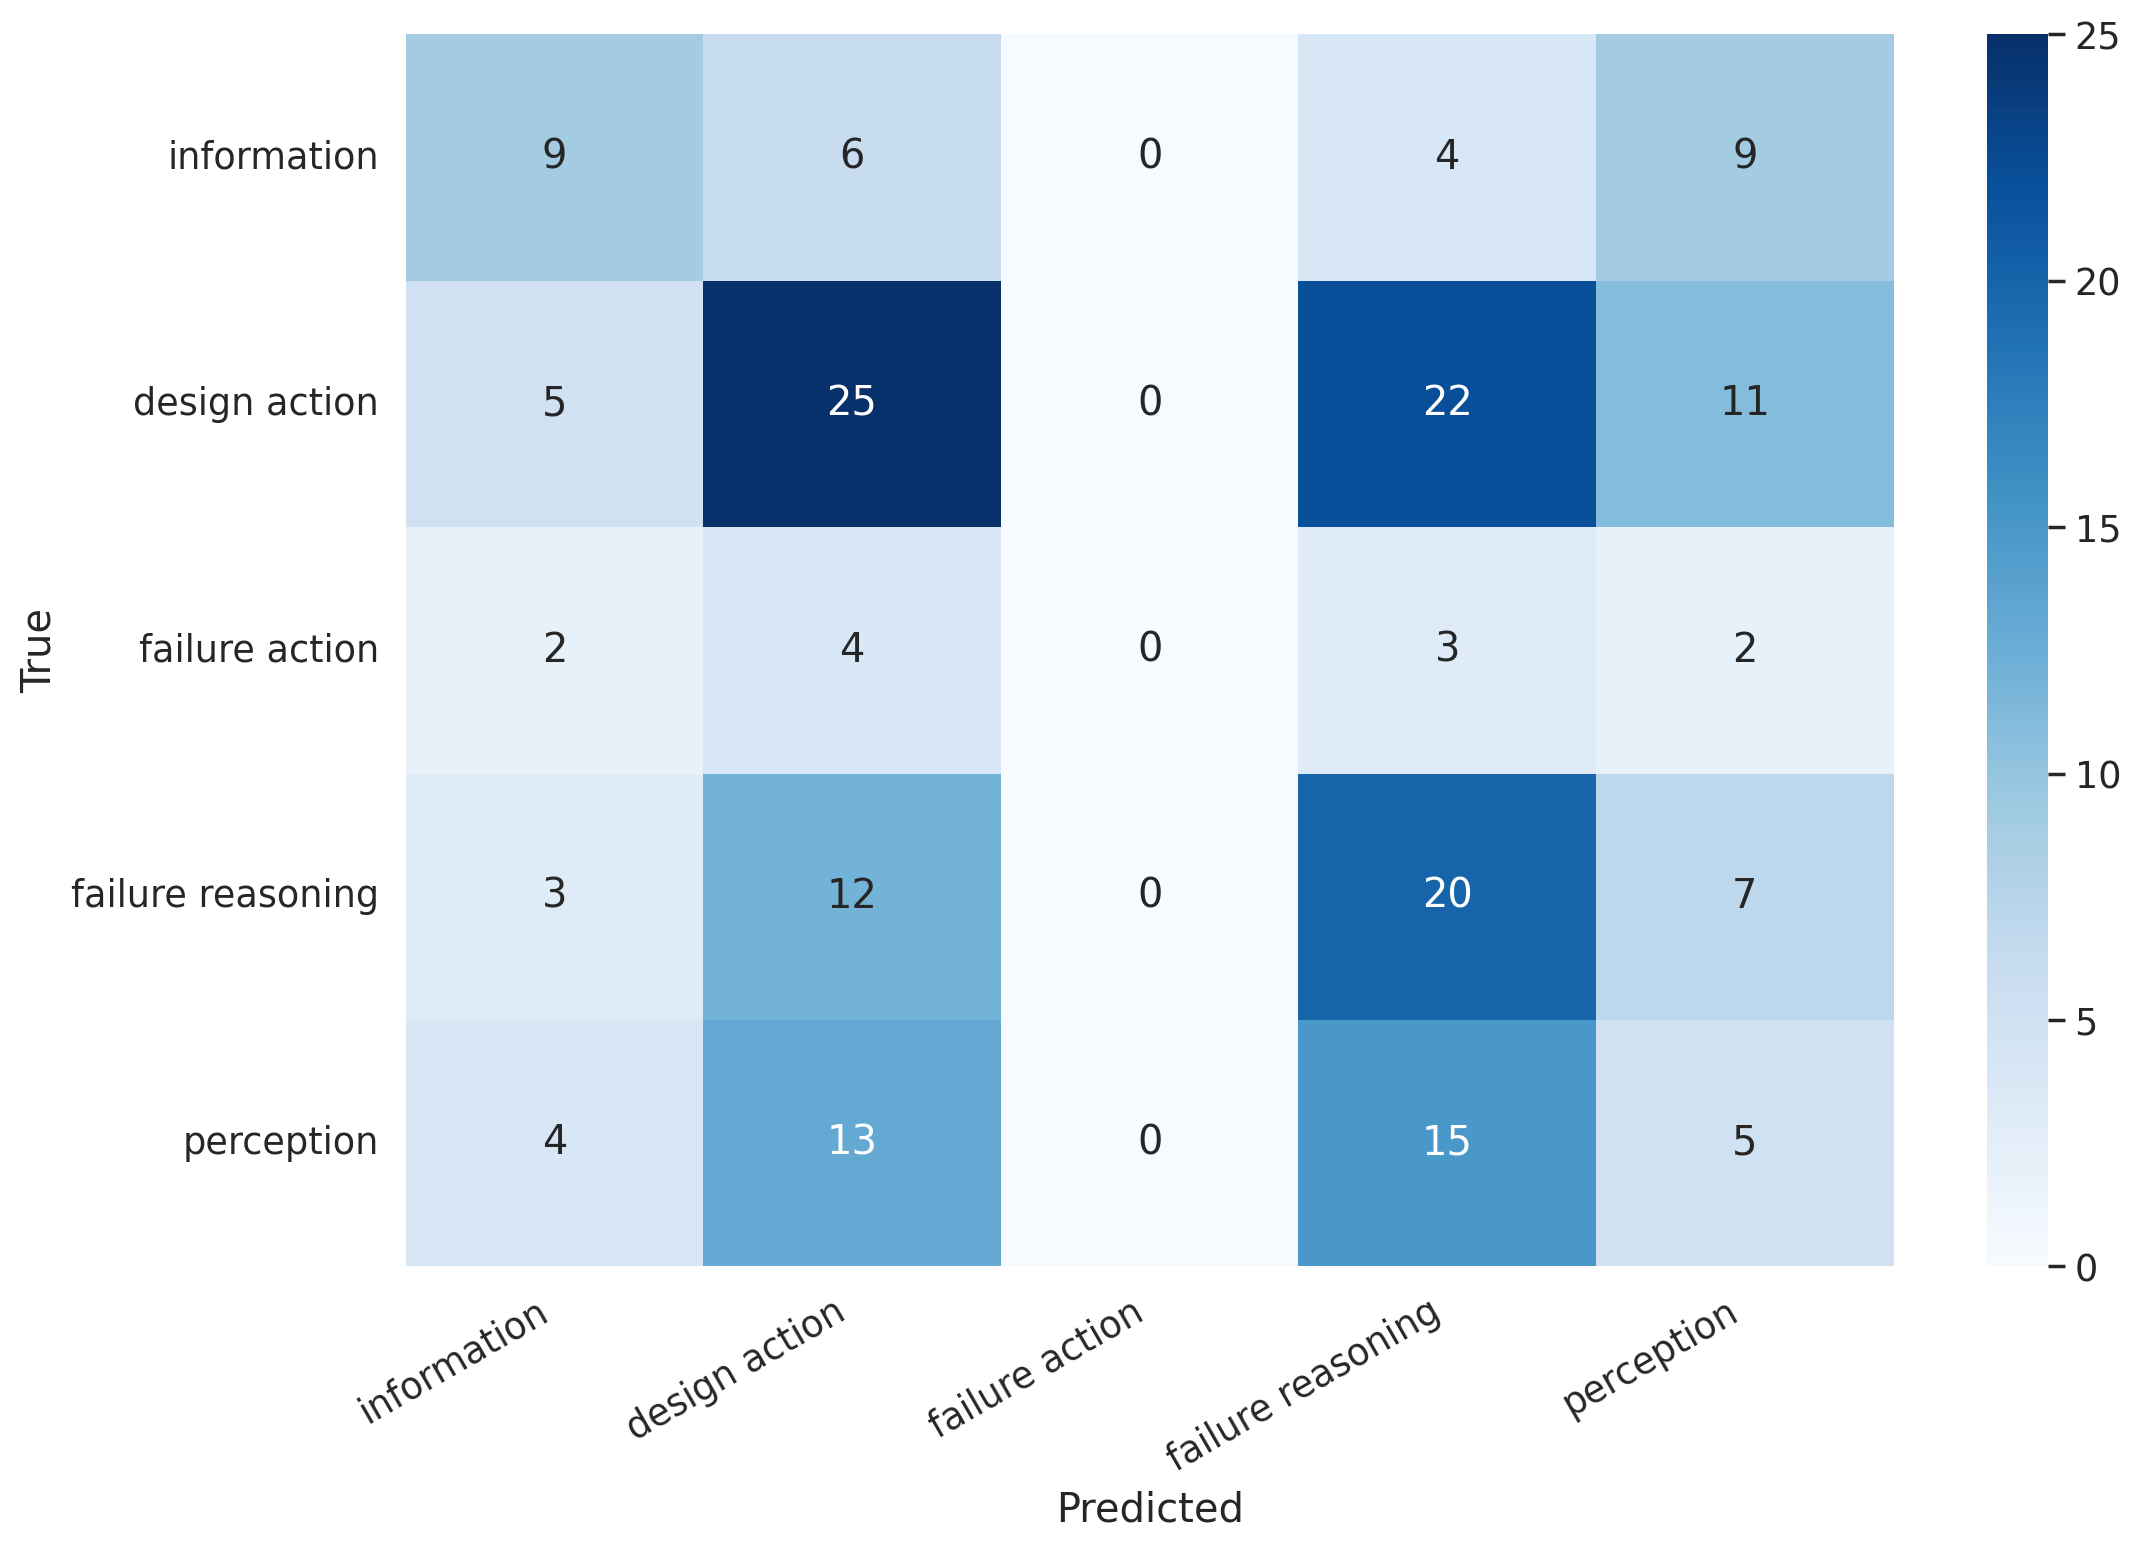

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.39      0.32      0.35        28
    design action       0.42      0.40      0.41        63
   failure action       0.00      0.00      0.00        11
failure reasoning       0.31      0.48      0.38        42
       perception       0.15      0.14      0.14        37

         accuracy                           0.33       181
        macro avg       0.25      0.27      0.26       181
     weighted avg       0.31      0.33      0.31       181

